### Algorithm to simulate the forward migration of meandering river channels.

This code contains an algorithm to analyze and simulate the behavior of meandering river channel. 
It uses geospatial data and mathematical computations to model the river's future migration and creates a simulation of potential future changes in the river channel.

The code below uses the Oulankajoki River as an example. By modifying the input parameters, such as the centerline, feasible region, and other required variables, this method can also be used to model other meandering rivers.



*Algorithm is part of Oona Oksanen's master's thesis (Pro gradu).*

** **
** **

Load river channel **centerline** and **feasible region** from shapefiles into GeoDataFrames for further processing.

In [17]:
import geopandas as gpd

# River channel centerline
centerline = gpd.read_file(r'C:\data\oulankajoki.shp')

# Feasible region
feasible_region = gpd.read_file(r'C:\data\sallittualue_maalajit2.shp')

** **
Plot centerline, feasible region and coordinates.

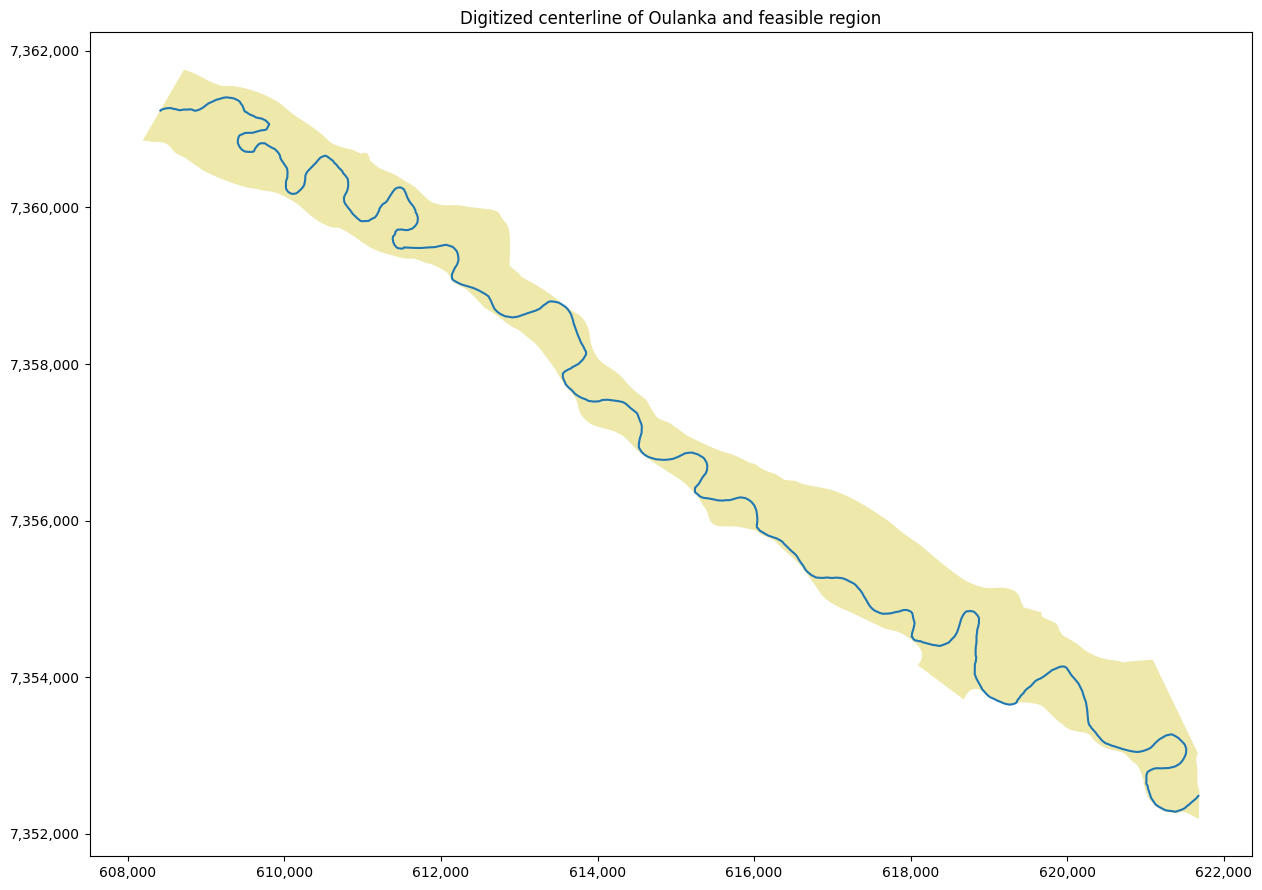

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

feasible_region.plot(ax=ax, color = 'palegoldenrod')

centerline.plot(ax=ax)

plt.title("Digitized centerline of Oulanka and feasible region")

plt.show()

** **
Divide centerline into **breakpoints** at given interval and smooth them with Savitzky-Golay filter.

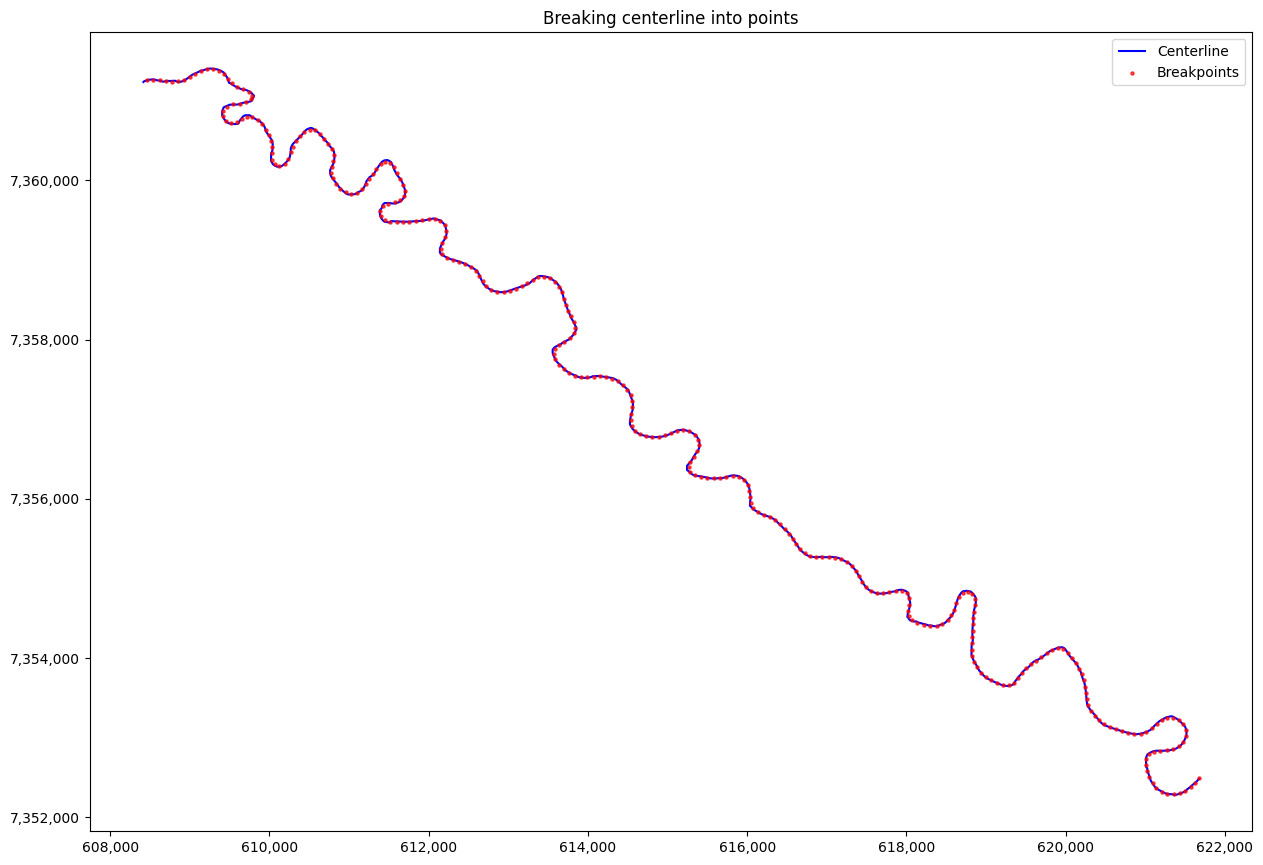

In [3]:
from shapely.geometry import LineString, Point
from scipy.signal import savgol_filter

# GeoDataFrame
points = gpd.GeoDataFrame(columns=['geometry'])

# Function to create breakpoints at given interval
def create_breakpoints(geometry, interval):

    breakpoints = LineString(geometry).interpolate(range(0, int(geometry.length), interval))

    #Smooth points using Savitzky-Golay filtering
    x_coords = [point.x for point in breakpoints]
    y_coords = [point.y for point in breakpoints]
    smoothed_x = savgol_filter(x_coords, window_length = 7, polyorder=3)
    smoothed_y = savgol_filter(y_coords, window_length = 7, polyorder=3)
    
    smoothed_breakpoints = [Point(x, y) for x, y in zip(smoothed_x, smoothed_y)]

    # Add points to gdf
    point = gpd.GeoDataFrame(geometry=smoothed_breakpoints, crs='EPSG:3067')
    return point[::-1] 

# Divide points
points = create_breakpoints(centerline['geometry'].iloc[0], 80)

# Plot 
fig, ax = plt.subplots(figsize=(15, 12))
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

centerline.plot(ax=ax, color = 'blue', zorder = 1, linewidth = 1.5, label = 'Centerline')
points.plot(ax=ax, color='red', marker='o', markersize=5, alpha = 0.7, label = 'Breakpoints')

plt.title("Breaking centerline into points")

ax.legend()
plt.show()


** **
B-spline curve to connect breakpoints back into a continuous line

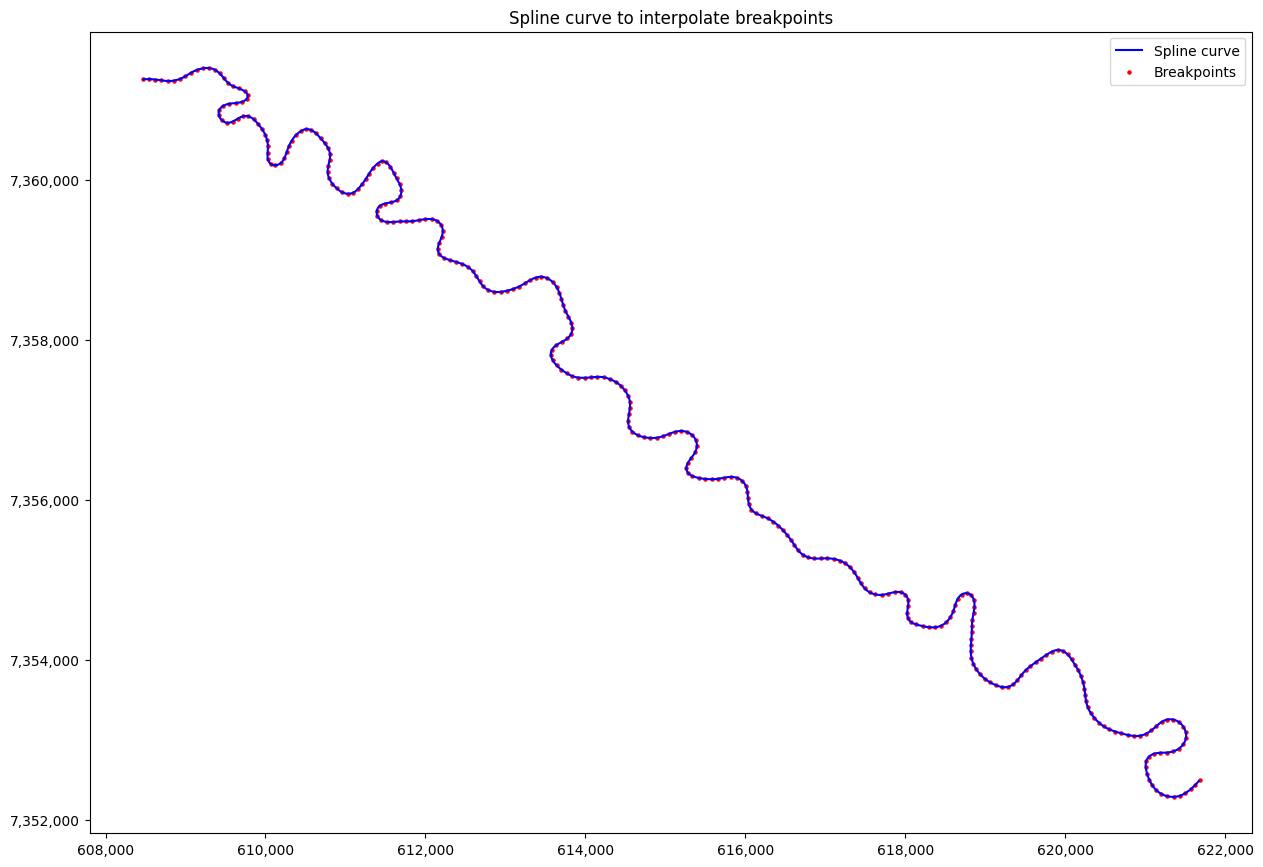

In [4]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_spline(points):

    x, y = zip(*points)

    # Spline parameters
    tck, u = splprep([x, y], s=3) 
    t_new = np.linspace(0, 1, 1000)
    spline_points = splev(t_new, tck)
    
    # Convert to Points
    spline_points = [Point(coord) for coord in zip(spline_points[0], spline_points[1])]
    bspline = LineString(spline_points)
    bspline_gdf = gpd.GeoDataFrame(geometry=[bspline])

    return bspline, bspline_gdf

# Generate spline curve
spline_ls, spline_gdf = create_spline(points['geometry'].apply(lambda point: (point.x, point.y)).tolist())

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

spline_gdf.plot(ax=ax, color='blue', label = 'Spline curve')

points.plot(ax=ax, color='red', marker='o', markersize=5, label = 'Breakpoints')

plt.title("Spline curve to interpolate breakpoints")

ax.legend()
plt.show()

** **
Detect **inflection points** by calculating dot products of consecutive vectors $u_i \cdot v_i^T$ and observe sign changes.

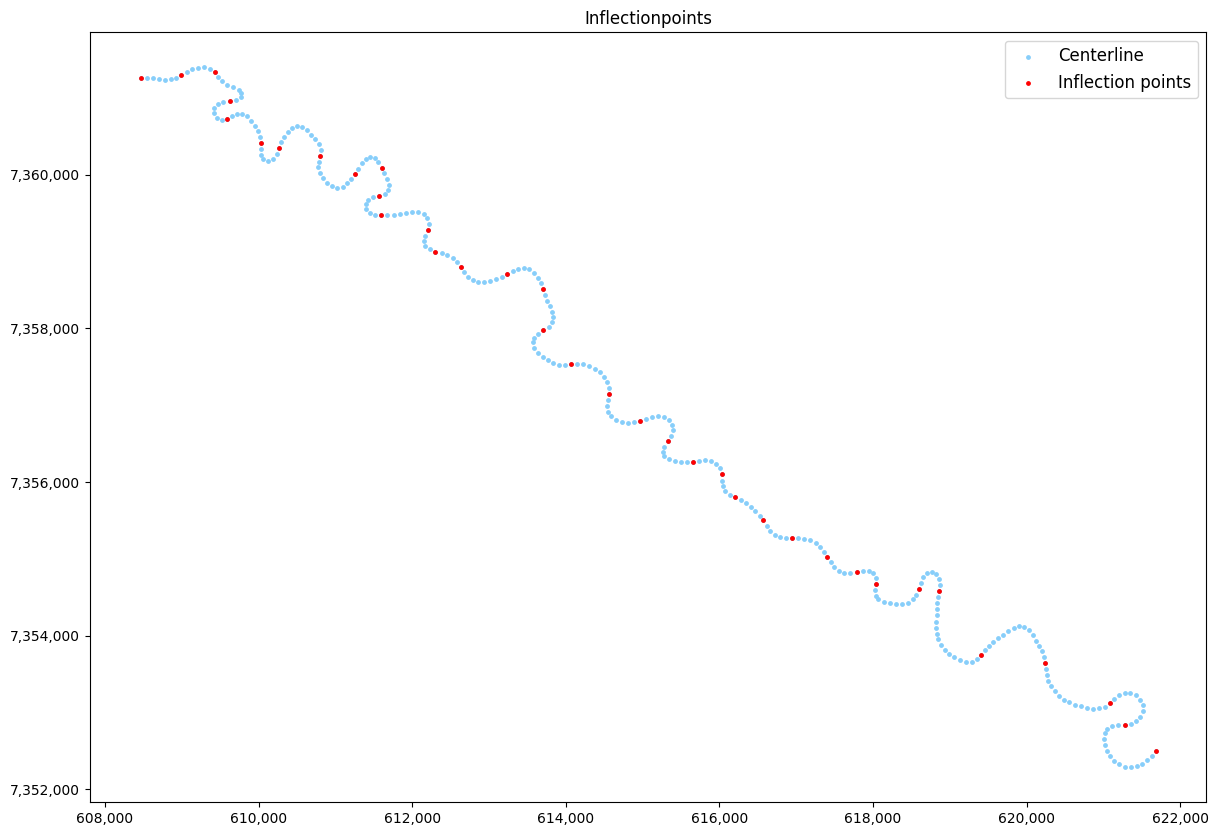

In [5]:
#Inflectionpoints defined by u_i * v_i^T

import numpy as np

def define_inflectionpoints(points, p_between):
    inflectionpoint_list = []
    points_in_between = 0
    inflectionpoint_list.append(points.iloc[0]) # First point

    for i in range(1, len(points)-2):

        # Vectors 
        v1 = (np.array(points.iloc[i-1].coords[0])) - (np.array(points.iloc[i].coords[0]))

        v2 = (np.array(points.iloc[i].coords[0])) - (np.array(points.iloc[i+1].coords[0]))
        v2_T = np.array([-v2[1], v2[0]])
        
        v3 = (np.array(points.iloc[i+1].coords[0])) - (np.array(points.iloc[i+2].coords[0]))
        v3_T = np.array([-v3[1], v3[0]])

        # Dot product
        dot_product1 = np.dot(v1, v2_T) # u_i * v_i^T
        dot_product2 = np.dot(v2, v3_T) # u_i+1 * v_i+1^T

        # Counter to ensure that there are at least 4 points between inflection points
        points_in_between = points_in_between + 1

        # Check when sign changes
        if np.sign(dot_product1) != np.sign(dot_product2) and points_in_between > p_between:
            inflectionpoint_list.append(points.iloc[i]) # Add to inflection point list
            
            points_in_between = 0
    inflectionpoint_list.append(points.iloc[len(points)-1]) # Last point
    
    return inflectionpoint_list

# Define inflection points
inflection_points = define_inflectionpoints(points['geometry'], 4)

# Plot
fig, ax = plt.subplots(figsize=(15, 10))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=6, label='Centerline')
gpd.GeoDataFrame(geometry=inflection_points).plot(ax=ax, color='red', marker='o', markersize=6, label='Inflection points')

plt.title("Inflectionpoints")

ax.legend(fontsize = 12)
plt.show()


** **
Define **meander bends** in the GeoDataFrame based on previously defined inflection points. 

In [6]:
# Define meander bends

def define_meander(points, inflectionpoints):
    points['meander'] = None
    meander_id = 0
    j = 1

    for i in range(len(points['geometry'])):
        if points['geometry'].iloc[i].coords[0] == inflectionpoints[j].coords[0]:
            points.at[len(points) - i - 1, 'meander'] = meander_id
            meander_id += 1
            if j != len(inflectionpoints) - 1:
                j += 1
        else:
            points.at[len(points) - i - 1, 'meander'] = meander_id

define_meander(points, inflection_points)

** **
Define **peak points** of meander bends as the points with maximum distance between midpoint of line between inflection points and meander points.

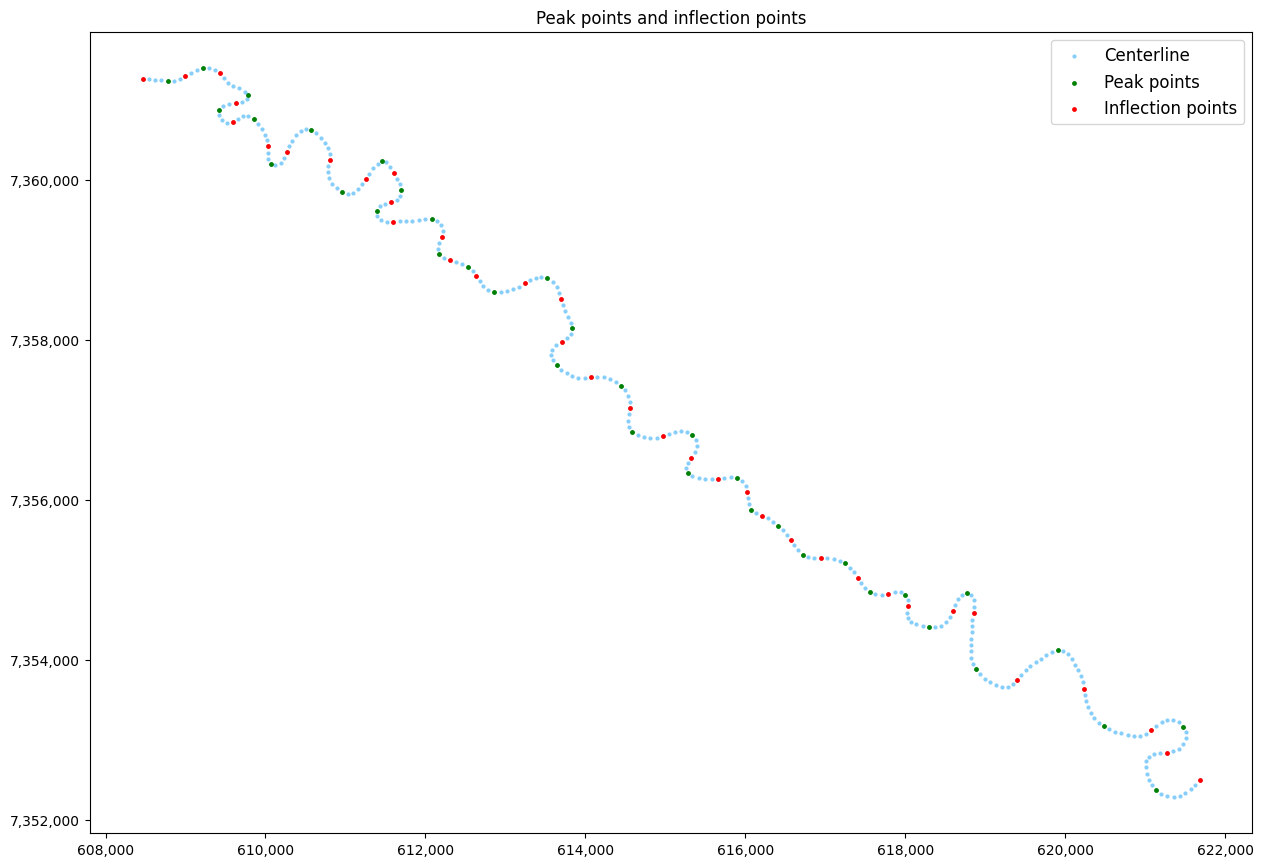

In [7]:
from shapely.geometry import Point, LineString

def define_peak_points(inflection_points, points):
    farthest_points = [] 
    max_distance = 0
    
    for i in range(len(inflection_points) - 1):
        p1 = inflection_points[i]
        p2 = inflection_points[i + 1]
        
        line = LineString([p1, p2])
        
        meander_points = points[points['meander'] == i]
        
        dist = []
        
        # Calculate distances of all points from line
        for j in range(len(meander_points)):
            distance = line.distance(meander_points['geometry'].iloc[j])
            dist.append(distance)
        
        max_distance = max(dist)  # Find max distance point
        farthest_point_index = dist.index(max_distance)  
        farthest_point = meander_points['geometry'].iloc[farthest_point_index]  
        
        farthest_points.append(farthest_point) 
        
    return farthest_points

peak = define_peak_points(inflection_points, points)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

points.plot(ax=ax, color='lightskyblue', marker='o', markersize=4, label= 'Centerline')

gpd.GeoDataFrame(geometry=peak).plot(ax=ax, color='green', marker='o', markersize=6, label='Peak points')
gpd.GeoDataFrame(geometry=inflection_points).plot(ax=ax, color='red', marker='o', markersize=6, label='Inflection points')

plt.title("Peak points and inflection points")

ax.legend(fontsize = 12)
plt.show()

** **
Calculate radius of circle that intersects three consecutive points.

In [8]:
import numpy as np

def radius_and_intersectionpoint(points):
    radius_list = []
    intersectionpoint_list = []

    for i in range(len(points) - 2):

        # Three consecutive points
        p1 = np.array(points['geometry'].iloc[i].coords[0])
        p2 = np.array(points['geometry'].iloc[i + 1].coords[0])
        p3 = np.array(points['geometry'].iloc[i + 2].coords[0])

        midpoint1 = 0.5 * (p1 + p2)
        normal1 = np.array([-(p2 - p1)[1], (p2 - p1)[0]])

        midpoint2 = 0.5 * (p2 + p3)
        normal2 = np.array([-(p3 - p2)[1], (p3 - p2)[0]])
       
        A = np.array([[normal1[0], -normal2[0]], [normal1[1], -normal2[1]]])
        B = np.array([midpoint2[0] - midpoint1[0], midpoint2[1] - midpoint1[1]])
        
        if np.linalg.det(A) == 0:
            print("Singular matrix. Skipping this point.")
            continue
        else:
            solution = np.linalg.solve(A, B)

            # intersection
            intersection_points = midpoint1 + solution[1] * normal1
            intersectionpoint_list.append(intersection_points)
        
            # radius
            radius = np.linalg.norm(intersection_points - p2)
            radius_list.append(radius)

    return radius_list, intersectionpoint_list, solution, A, B 

rad, inter, sol, A, B = radius_and_intersectionpoint(points)


** **
Calculate **curvature** $\kappa(x_i) = \frac{1}{r_i}$ for each point. 

C:\Users\oonao\AppData\Local\Temp\ipykernel_8268\3191909994.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  points['curvature'][:-2] = curvature_list
C:\Users\oonao\AppData\Local\Temp\ipykernel_8268\3191909994.py:18: SettingWithCopyWarn

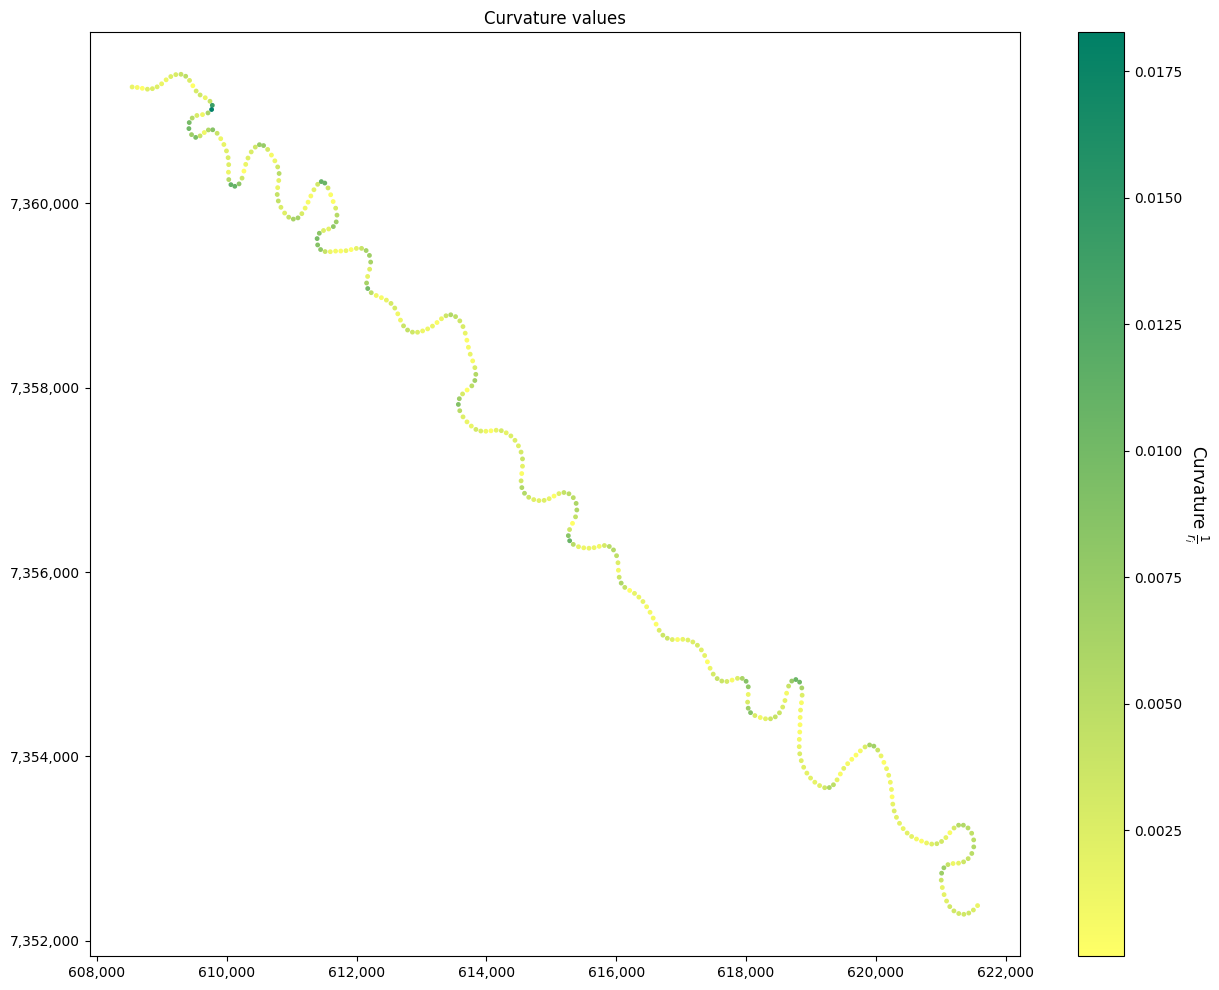

In [9]:
#Curvature 1/r

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def calculate_curvature(points, radius):
    curvature_list = []
    shifted_radius = [np.nan] + radius[:-1]

    points['curvature'] = np.nan

    for i in range(len(points) - 2):
        radius = shifted_radius[i]
        curvature = 1 / radius
        curvature_list.append(curvature)

    points['curvature'][:-2] = curvature_list 

calculate_curvature(points, rad)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['curvature'],
    cmap= 'summer_r',
    s=6
)

cbar = plt.colorbar(scatter, label='Curvature')
cbar.set_label(r'Curvature $\frac{1}{r_i}$', rotation=270, labelpad=20, fontsize = 12)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

plt.title("Curvature values")

plt.show()


** **
**Normalize curvature values** within each meander by maximum curvature of meander $\frac{\kappa(x_i)}{\max \kappa_j}$.

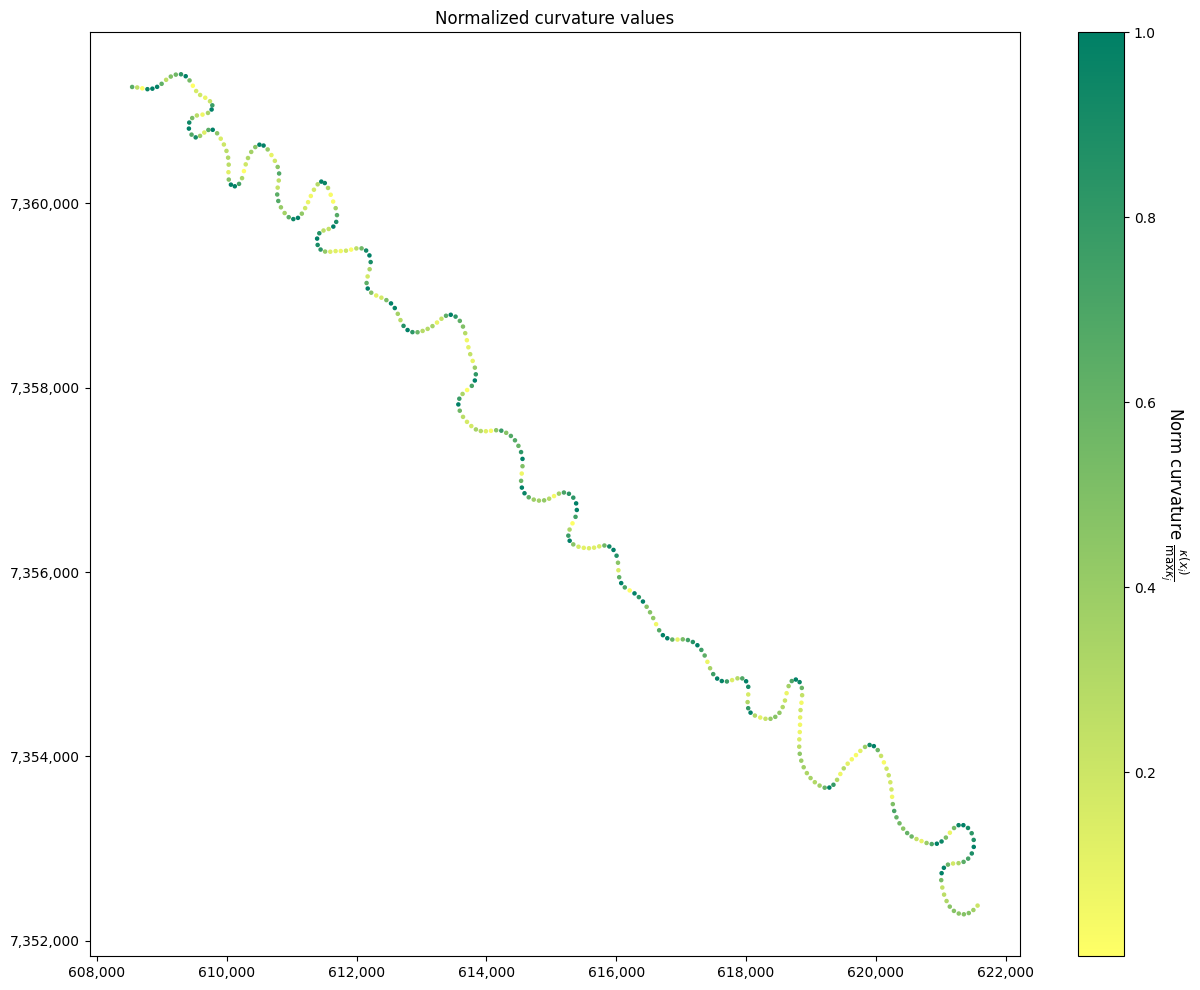

In [10]:
# Norm curvature

def define_normalized_curvature(points):
    points['norm_curvature'] = None

    for i in range(max(points['meander'])+1): 

            pm = (points['meander'] == i)
            filtered_pm = points[pm]

            maxcurvature = filtered_pm['curvature'].max()

            for index in filtered_pm.index:
                points.loc[index, 'norm_curvature'] = filtered_pm.loc[index, 'curvature'] / maxcurvature

define_normalized_curvature(points)

# Plot
 
fig, ax = plt.subplots(figsize=(15, 12))
scatter = ax.scatter(
    points.geometry.x,
    points.geometry.y,
    c=points['norm_curvature'],
    cmap='summer_r',
    s=5
)

cbar = plt.colorbar(scatter, label='Norm curvature')
cbar.set_label(r'Norm curvature $\frac{\kappa(x_i)}{\max \kappa_j}$', rotation=270, labelpad=25, fontsize = 12)

def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

plt.title("Normalized curvature values")

plt.show()
                  

** **
Check if the point is located within the **feasible region**.

In [11]:
def check_feasible_region(prev, point, feasibleregion):

    if Point(point).within(feasibleregion.geometry.iloc[0]):
        new_p = Point(point)
    else:
        new_p = prev

    return new_p

** **
Formation of **oxbow lakes**

In [12]:
import geopandas as gpd
import pandas as pd

# Oxbow lakes

def new_oxbow(points, inflection, peak, meters):
    new_points = points.copy()
    oxbows = []

    # Check distances between inflection points and peak points
    for i in range(len(peak)):
        for j in range(i + 1, len(peak)): 
            if inflection[i].distance(inflection[j]) < meters or peak[i].distance(peak[j]) < meters or inflection[i].distance(peak[j]) < meters:
                
                min_meander = min(i, j)
                max_meander = max(i, j)
                
                # Select all points that lie between the points to be connected
                oxbow_points = new_points[(new_points['meander'] >= min_meander) & (new_points['meander'] <= max_meander)]
                
                if not oxbow_points.empty:
                    oxbows.append(gpd.GeoDataFrame(oxbow_points, geometry='geometry'))

                # Update river channel points without oxbow points
                new_points = new_points[~((new_points['meander'] >= min_meander) & (new_points['meander'] <= max_meander))]

    if oxbows:
        oxbow_gdf = pd.concat(oxbows, ignore_index=True)
    else:
        oxbow_gdf = gpd.GeoDataFrame()

    return new_points, oxbow_gdf


** **
Define **directions** **D** and **L**, where **D** represents direction between inflection points and **L** represents direction from their midpoint to the peak point.

In [13]:
import math

def define_directions_peak(inflectionpoints, peakpoints):
    D_list = []
    L_peak_list = []
    j = 0
    
    for i in range(len(inflectionpoints) - 1):

        # D points
        x1_inf, y1_inf = inflectionpoints[i].x, inflectionpoints[i].y
        x2_inf, y2_inf = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Direction of D
        v_inf = (x2_inf - x1_inf, y2_inf - y1_inf)

        # Length of D
        v_inf_length = math.sqrt(v_inf[0] ** 2 + v_inf[1] ** 2) 

        # Norm D
        D = (v_inf[0] / v_inf_length, v_inf[1] / v_inf_length)
    
        # L points
        x_mid , y_mid  = 0.5*(x1_inf + x2_inf) , 0.5*(y1_inf + y2_inf)
        x_peak, y_peak = peakpoints[j].x, peakpoints[j].y
        j = j+1

        # Direction L
        v_peak = (x_peak - x_mid, y_peak - y_mid)

        # Length L
        v_peak_length = math.sqrt(v_peak[0] ** 2 + v_peak[1] ** 2)

        # Norm L
        L = (v_peak[0] / v_peak_length, v_peak[1] / v_peak_length)

        D_list.append(D)
        L_peak_list.append(L)

    return D_list, L_peak_list

D, L = define_directions_peak(inflection_points, peak)


** **
Define migration **offsets $O_D(x_i)$** and **$O_L(x_i)$**.

*Model is created by Parquer, M. N., Collon, P., & Caumon, G. (2017). Reconstruction of Channelized Systems Through a Conditioned Reverse Migration Method.*

In [14]:
def offsets(points, OD, OL, sD, sL, w):
    od_xi = []
    ol_xi = []

    max_curvature=points['curvature'].max()

    for i in range(len(points)):
            
        if w > 0:
            OD_xi = OD - (sD * (points['curvature'].iloc[i] / max_curvature))

            OL_xi = OL - (sL * (1 - (points['curvature'].iloc[i] / max_curvature)))

        elif w < 0:
            OD_xi = OD - (sD * (1 - (points['curvature'].iloc[i] / max_curvature)))

            OL_xi = OL - (sL * (points['curvature'].iloc[i] / max_curvature))


        od_xi.append(OD_xi)
        ol_xi.append(OL_xi)

    return od_xi, ol_xi

** **
**Algorithm to simulate river channel furute migration.**

C:\Users\oonao\AppData\Local\Temp\ipykernel_8268\3191909994.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  points['curvature'][:-2] = curvature_list
C:\Users\oonao\AppData\Local\Temp\ipykernel_8268\3191909994.py:18: SettingWithCopyWarn

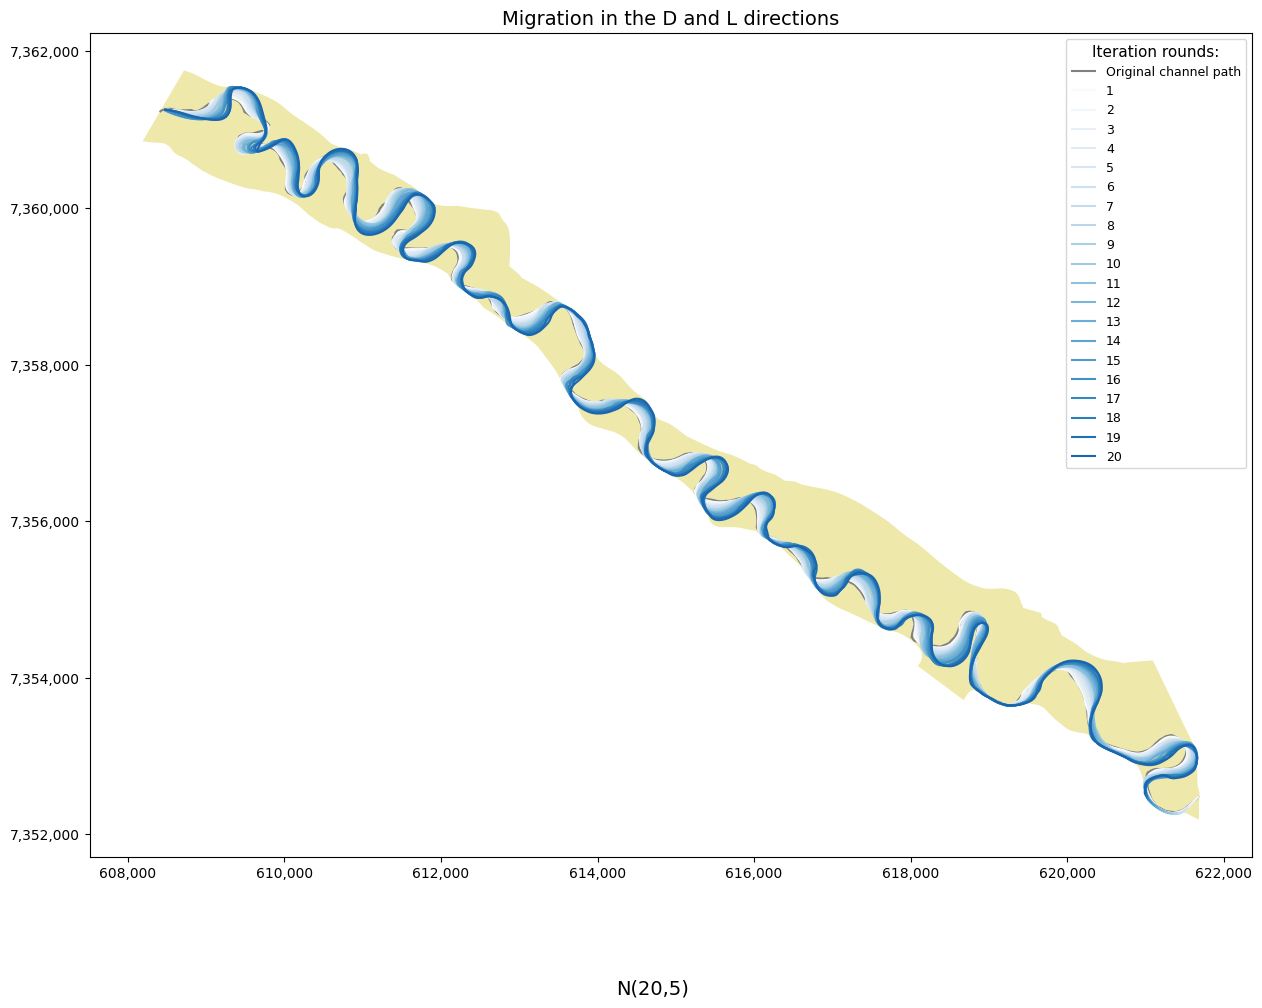

In [15]:
#ALGORITHM

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset, cut_off_distance, feasible_region):
    new_points = {}
    spline = {}
    spline_gdf = {}
    oxbow_points = []

    for s in range(N_s):

        # Initialize a GeoDataFrame to store the new points
        new_points[s] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'meander'])

        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], 4)

        # Define meander bends
        define_meander(channel_path, inflection_points)
        new_points[s]['meander'] = channel_path['meander']

        # Define peak points
        peak = define_peak_points(inflection_points, channel_path)
        
        # Radius of circles which are defined by three consecutive points
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        new_points[s]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        D_direction, L_direction = define_directions_peak(inflection_points, peak)

        # Sample horizontal and lateral offsets from Gaussian distribution

        '''

        By changing these: 

        1.Pure lateral migration : OD = 0 and OL ~ N(mean,sd), 

        2.Pure downstream migration : OD ~ N(mean, sd) and  OL = 0, 

        3.Mixed migration : OD ~ N(mean, sd) and OL ~ N(mean,sd), 
        
        '''
    
        OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OD = np.zeros(N_hm)
        
        OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OL = np.zeros(N_hm)

        # Sample smoothing values sL and sD from a uniform distribution

        min_sD = 0
        max_sD = 2*OD

        min_sL = 0
        max_sL = 2*OL

        sD = np.random.uniform(min_sD, max_sD)

        sL = np.random.uniform(min_sL, max_sL) 
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one meander
            pm = (channel_path['meander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            # Move points

            for pn in range(len(filtered_pm['geometry'])):
                
                new_point = (
                    filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *  L_direction[hm][0])) ,
                    filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *  L_direction[hm][1]))
                    )
                if not np.isnan(new_point).all():
                    newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                    newpoint_list.append(newpoint)
                else:
                    newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                    newpoint_list.append(Point(newpoint)) 
            
                
        # Add new points to the GeoDataFrame
        new_points[s]['geometry'] = newpoint_list

        # Check if new oxbow lakes will appear
        channel_path_deleted_oxbows, oxbows = new_oxbow(channel_path, inflection_points, peak, cut_off_distance)


        # If there is new oxbow lakes
        if len(oxbows) > 0: 
            
            # Add points without oxbow bends
            new_points[s]=gpd.GeoDataFrame(columns=['geometry'])
            new_points[s]['geometry'] = [Point((point.x, point.y)) for point in channel_path_deleted_oxbows['geometry']]

            oxbow_points.append(oxbows)

        # Spline
        spline[s], spline_gdf[s] = create_spline((new_points[s]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # Update new path to next round
        channel_path = create_breakpoints(spline[s], 80)
        channel_path['geometry'] = channel_path['geometry'].iloc[::-1].values
        
    # Plot

    fig, ax = plt.subplots(figsize =(15,12))

    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

    feasible_region.plot(ax=ax, color = 'palegoldenrod')
    
    # Original channel_path
    centerline.plot(ax=ax, color='grey', label='Original channel path')
    
    # Splines of rounds
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        gpd.GeoDataFrame(geometry=[spline[i]]).plot(ax=ax, color=color, label=f'{i+1}')

    #title_txt = "Migration in the L-direction"
    #title_txt = "Migration in the D-direction"
    title_txt = "Migration in the D and L directions"



    # Set title
    plt.title(title_txt, fontsize=14)
    suptitle_text = f'N({mean_offset},{std_dev_offset})'
    plt.suptitle(suptitle_text, x=0.5, y=0.05, ha='center', fontsize = 14)
    
    plt.legend(title="Iteration rounds:", title_fontsize=11,  fontsize=9)

    plt.show()


'''

Input:

N_s: Number of simulations.

channel_path: Current river channel.

mean_offset: Average D and L migration distance.
std_dev_offset: Standard deviation of D and L migration distances.

cut_off: Cut-off distance for oxbow lakes.
feasible_region: Feasible region for channel migration.

'''

N_s = 20

channel_path = points

mean_offset = 20
std_dev_offset = 5

# Negative offset
#mean_offset = 0    
#std_dev_offset = 10

cut_off = 100 #oulanka

feasible_region = feasible_region

reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset,  cut_off, feasible_region)


The same algorithm, but without using the feasible region to constrain migration.

C:\Users\oonao\AppData\Local\Temp\ipykernel_8268\3191909994.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  points['curvature'][:-2] = curvature_list
C:\Users\oonao\AppData\Local\Temp\ipykernel_8268\3191909994.py:18: SettingWithCopyWarn

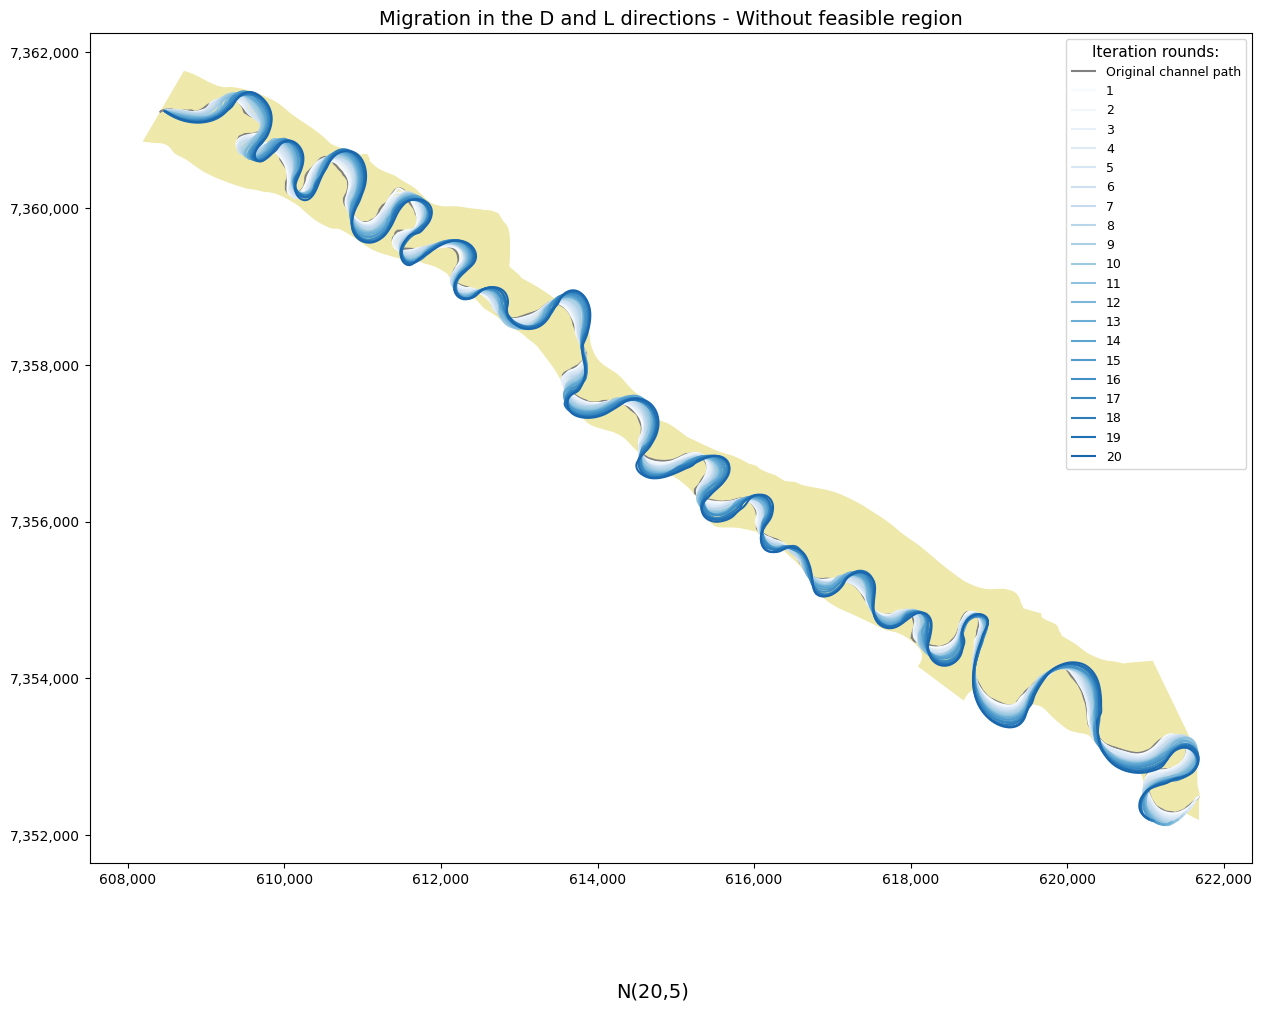

In [16]:
#ALGORITHM without feasible region

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset, cut_off_distance, feasible_region):
    new_points = {}
    spline = {}
    spline_gdf = {}
    oxbow_points = []

    for s in range(N_s):

        # Initialize a GeoDataFrame to store the new points
        new_points[s] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'meander'])

        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], 4)

        # Define meander bends
        define_meander(channel_path, inflection_points)
        new_points[s]['meander'] = channel_path['meander']

        # Define peak points
        peak = define_peak_points(inflection_points, channel_path)
        
        # Radius of circles which are defined by three consecutive points
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        new_points[s]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        D_direction, L_direction = define_directions_peak(inflection_points, peak)

        # Sample horizontal and lateral offsets from Gaussian distribution

        '''

        By changing these: 

        1.Pure lateral migration : OD = 0 and OL ~ N(mean,sd), 

        2.Pure downstream migration : OD ~ N(mean, sd) and  OL = 0, 

        3.Mixed migration : OD ~ N(mean, sd) and OL ~ N(mean,sd), 
        
        '''
    
        OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OD = np.zeros(N_hm)
        
        OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OL = np.zeros(N_hm)

        # Sample smoothing values sL and sD from a uniform distribution

        min_sD = 0
        max_sD = 2*OD

        min_sL = 0
        max_sL = 2*OL

        sD = np.random.uniform(min_sD, max_sD)

        sL = np.random.uniform(min_sL, max_sL) 
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one meander
            pm = (channel_path['meander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            # Move points, no checking feasible region

            for pn in range(len(filtered_pm['geometry'])):
                
                new_point = (
                    filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *  L_direction[hm][0])) ,
                    filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *  L_direction[hm][1]))
                    )
                if not np.isnan(new_point).all():
                    newpoint = Point(new_point)
                    newpoint_list.append(newpoint)
                else:
                    newpoint = Point(filtered_pm['geometry'].iloc[pn].x, filtered_pm['geometry'].iloc[pn].y)
                    newpoint_list.append(newpoint)
            
                
        # Add new points to the GeoDataFrame
        new_points[s]['geometry'] = newpoint_list

        # Check if new oxbow lakes will appear
        channel_path_deleted_oxbows, oxbows = new_oxbow(channel_path, inflection_points, peak, cut_off_distance)


        # If there is new oxbow lakes
        if len(oxbows) > 0: 
            
            # Add points without oxbow bends
            new_points[s]=gpd.GeoDataFrame(columns=['geometry'])
            new_points[s]['geometry'] = [Point((point.x, point.y)) for point in channel_path_deleted_oxbows['geometry']]

            oxbow_points.append(oxbows)

        # Spline
        spline[s], spline_gdf[s] = create_spline((new_points[s]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # Update new path to next round
        channel_path = create_breakpoints(spline[s], 80)
        channel_path['geometry'] = channel_path['geometry'].iloc[::-1].values
        
    # Plot

    fig, ax = plt.subplots(figsize =(15,12))

    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

    feasible_region.plot(ax=ax, color = 'palegoldenrod')
    
    # Original channel_path
    centerline.plot(ax=ax, color='grey', label='Original channel path')
    
    # Splines of rounds
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        gpd.GeoDataFrame(geometry=[spline[i]]).plot(ax=ax, color=color, label=f'{i+1}')

    #title_txt = "Migration in the L-direction - Without feasible region"
    #title_txt = "Migration in the D-direction - Without feasible region"
    title_txt = "Migration in the D and L directions - Without feasible region"



    # Set title
    plt.title(title_txt, fontsize=14)
    suptitle_text = f'N({mean_offset},{std_dev_offset})'
    plt.suptitle(suptitle_text, x=0.5, y=0.05, ha='center', fontsize = 14)
    
    plt.legend(title="Iteration rounds:", title_fontsize=11,  fontsize=9)

    plt.show()


'''

Input:

N_s: Number of simulations.

channel_path: Current river channel.

mean_offset: Average D and L migration distance.
std_dev_offset: Standard deviation of D and L migration distances.

cut_off: Cut-off distance for oxbow lakes.
feasible_region: Feasible region for channel migration.

'''

N_s = 20

channel_path = points

mean_offset = 20
std_dev_offset = 5

# Negative offset
#mean_offset = 0    
#std_dev_offset = 10

cut_off = 100 #oulanka

feasible_region = feasible_region

reverse_migration_simulation(N_s, channel_path, mean_offset, std_dev_offset,  cut_off, feasible_region)
